# Detect the sound of engines with machine learning
<h4>Blake Rayvid - <a href=https://github.com/brayvid>https://github.com/brayvid</a></h4>

# Start from scratch from dataset

In [ ]:
!pip install resampy

In [ ]:
# Generate X and y from audio files - MFCC, mean power, entropy
import os
import numpy as np
import librosa
import logging
from sklearn.preprocessing import LabelEncoder
from scipy.stats import entropy

logging.basicConfig(level=logging.DEBUG)

def extract_features(file_path, max_len=212):
    try:
        # Load audio file
        audio, sample_rate = librosa.load(file_path, sr=None, res_type='kaiser_fast')

        # Generate MFCC
        mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=13, n_fft=2048, hop_length=512)

        # Calculate mean power
        mean_power = np.mean(librosa.feature.rms(y=audio))

        # Calculate entropy
        power_spectrum = np.abs(librosa.stft(audio, n_fft=2048, hop_length=512))**2
        power_distribution = power_spectrum / np.sum(power_spectrum)
        signal_entropy = entropy(np.mean(power_distribution, axis=1))

        # Pad or truncate MFCC
        if mfcc.shape[1] < max_len:
            pad_width = max_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :max_len]

        # Add mean power and entropy as features
        mean_power_feature = np.full((1, max_len), mean_power)
        entropy_feature = np.full((1, max_len), signal_entropy)
        features = np.vstack((mfcc, mean_power_feature, entropy_feature))

        return features

    except FileNotFoundError:
        logging.error(f"File not found: {file_path}")
        return None
    except ValueError as ve:
        logging.error(f"Value error while processing file {file_path}: {ve}")
        return None
    except Exception as e:
        logging.error(f"Error processing file {file_path}: {e}")
        return None

def load_data(data_dir, max_len=212):
    features = []
    labels = []
    class_names = ['engine', 'non_engine']

    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        for file_name in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file_name)
            if file_path.endswith('.wav'):
                data = extract_features(file_path, max_len=max_len)
                if data is not None:
                    features.append(data)
                    labels.append(class_name)

    return np.array(features), np.array(labels)

# Load data
data_dir = '/content/drive/MyDrive/PROJECTS/Flatiron/Phase_4_Project/data'
max_len = 212
X, y = load_data(data_dir, max_len=max_len)

if len(X) == 0:
    logging.error("No valid features extracted.")
else:
    logging.info(f"Extracted features from {len(X)} files.")

# Encode labels
le = LabelEncoder()
y = le.fit_transform(y)


# Class names
class_names = le.classes_

In [ ]:
import pickle

# Save X and y to files using pickle
with open('/content/drive/MyDrive/PROJECTS/Flatiron/Phase_4_Project/X_engine.pkl', 'wb') as f:
    pickle.dump(X, f)
with open('/content/drive/MyDrive/PROJECTS/Flatiron/Phase_4_Project/y_engine.pkl', 'wb') as f:
    pickle.dump(y, f)

# Start from saved pickle files

In [ ]:
import pickle

# Load X and y from pickle file
with open('/content/drive/MyDrive/PROJECTS/Flatiron/Phase_4_Project/X_engine.pkl', 'rb') as f:
    X = pickle.load(f)
with open('/content/drive/MyDrive/PROJECTS/Flatiron/Phase_4_Project/y_engine.pkl', 'rb') as f:
    y = pickle.load(f)

# XGBoost classifier

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, classification_report, ConfusionMatrixDisplay
import joblib
from xgboost import XGBClassifier
from scipy.stats import uniform, randint

# Flatten the image data to 2D array for XGBoost
X_flat = X.reshape(X.shape[0], -1)

# Split the data into training and testing sets with 10% test size
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.1, stratify=y)

# Create a pipeline with StandardScaler and XGBClassifier configured to use GPU
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(eval_metric='logloss', tree_method='hist', device='cuda'))
])

# Define a smaller parameter grid for RandomizedSearchCV
param_dist = {
    'xgb__n_estimators': randint(50, 100),
    'xgb__max_depth': randint(3, 6),
    'xgb__learning_rate': uniform(0.01, 0.1)
}

# Use threading backend to avoid memory issues with loky
with joblib.parallel_backend('threading'):
    random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=10, cv=3, scoring='roc_auc', n_jobs=2)
    random_search.fit(X_train, y_train)

# Save the model for later use
joblib.dump(random_search.best_estimator_, '/content/drive/MyDrive/PROJECTS/Flatiron/Phase_4_Project/xgb_model.pkl')


['/content/drive/MyDrive/PROJECTS/Flatiron/Phase_4_Project/xgb_model.pkl']

## Evaluate

Best parameters found:  {'xgb__learning_rate': 0.09301604656647725, 'xgb__max_depth': 4, 'xgb__n_estimators': 84}
Best cross-validation ROC-AUC:  0.9211445554784937
ROC-AUC: 0.7065677966101696
              precision    recall  f1-score   support

      engine       0.58      0.46      0.51        24
  non-engine       0.93      0.95      0.94       177

    accuracy                           0.90       201
   macro avg       0.75      0.71      0.73       201
weighted avg       0.89      0.90      0.89       201



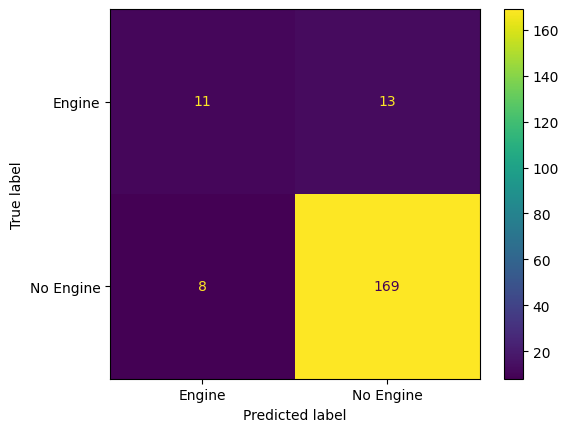

In [ ]:
# Print the best parameters and best score
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation ROC-AUC: ", random_search.best_score_)

# Evaluate the model on the test set
xgb_predictions = random_search.predict(X_test)

# Display ROC-AUC
roc_auc = roc_auc_score(y_test, xgb_predictions)
print(f"ROC-AUC: {roc_auc}")

# Classification report
print(classification_report(y_test, xgb_predictions, target_names=['engine', 'non-engine']))

# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, xgb_predictions, display_labels=['Engine', 'No Engine'])
plt.show()

## Notes
- Performance depends strongly on particular train-test split.


# CNN classifier ⭐️

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

# Adjust input shape
num_features = 15  # 13 MFCCs + 1 mean power + 1 entropy
input_shape = (num_features, X_train.shape[2], 1)

# Reshape data
X_train = X_train.reshape(X_train.shape[0], num_features, X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], num_features, X_test.shape[2], 1)

# Define CNN model
model = Sequential()

# First convolutional layer
model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D((2, 2)))

# Second convolutional layer
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D((2, 2)))

# Third convolutional layer
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D((2, 2)))

# Flatten and dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

# Compile model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Summary of model
model.summary()

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model with early stopping
history = model.fit(X_train, y_train, epochs=50, validation_split=0.1, callbacks=[early_stopping])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_65"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_195 (Conv2D)                  │ (None, 15, 212, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_195              │ (None, 15, 212, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_195 (ReLU)                     │ (None, 15, 212, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_195 (MaxPooling2D)     │ (None, 7, 106, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_196 (Conv2D)                  │ (None, 7, 106, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_196              │ (None, 7, 106, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_196 (ReLU)                     │ (None, 7, 106, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_196 (MaxPooling2D)     │ (None, 3, 53, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_197 (Conv2D)                  │ (None, 3, 53, 128)          │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_197              │ (None, 3, 53, 128)          │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_197 (ReLU)                     │ (None, 3, 53, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_197 (MaxPooling2D)     │ (None, 1, 26, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_65 (Flatten)                 │ (None, 3328)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_130 (Dense)                    │ (None, 128)                 │         426,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_65 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_131 (Dense)                    │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 519,938 (1.98 MB)

 Trainable params: 519,490 (1.98 MB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 114ms/step - accuracy: 0.8374 - loss: 0.7894 - val_accuracy: 0.8840 - val_loss: 0.4823
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8896 - loss: 0.2361 - val_accuracy: 0.9006 - val_loss: 0.3186
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8818 - loss: 0.2283 - val_accuracy: 0.8508 - val_loss: 0.3346
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8822 - loss: 0.2299 - val_accuracy: 0.8508 - val_loss: 0.3336
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8971 - loss: 0.2090 - val_accuracy: 0.8895 - val_loss: 0.3152
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9019 - loss: 0.2213 - val_accuracy: 0.8508 - val_loss: 0.2901
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9079 - loss: 0.2097 - val_accuracy: 0.8785 - val_loss: 0.4757
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9076 - loss: 0.2115 - val_accuracy: 0.8729 - val_lo

## Evaluate

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8574 - loss: 0.2239
Test accuracy: 0.8606964945793152
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
ROC-AUC: 0.7588276836158192
              precision    recall  f1-score   support

      engine       0.44      0.62      0.52        24
  non-engine       0.95      0.89      0.92       177

    accuracy                           0.86       201
   macro avg       0.69      0.76      0.72       201
weighted avg       0.89      0.86      0.87       201



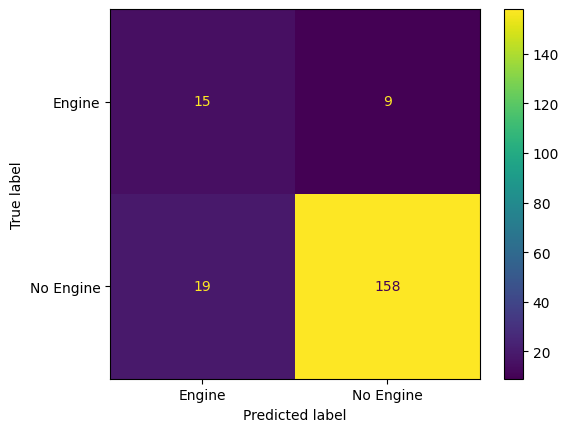

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_auc_score, classification_report, ConfusionMatrixDisplay

# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")

# Get test set predictions
y_pred = np.argmax(model.predict(X_test), axis=1)

# Display ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC: {roc_auc}")

# Classification report
print(classification_report(y_test, y_pred, target_names=['engine', 'non-engine']))

# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['Engine', 'No Engine'])
plt.show()

## Notes
- <s>Poor recall w/r/t engine class. Misclassifies most true engines.</s> Doing better with the additional features.
- The recall score for engine class depends strongly on the particular train test split.

# Model comparison
<table>
<th>Model
<td>ROC-AUC
<td>F1-Engine
<td>Recall-Engine
<td>Best
</th>
<tr>
<td>XGBoost
<td>0.70
<td>0.51
<td>0.46
<td>
</tr>
<tr>
<td>CNN
<td>0.80
<td>0.64
<td>0.67
<td>⭐️
</tr>
</table>

# To do
- <s>Perform more advanced feature extraction before passing to a model.</s> Done.
- Make visualizations and slides for presentation.

# Visualizations

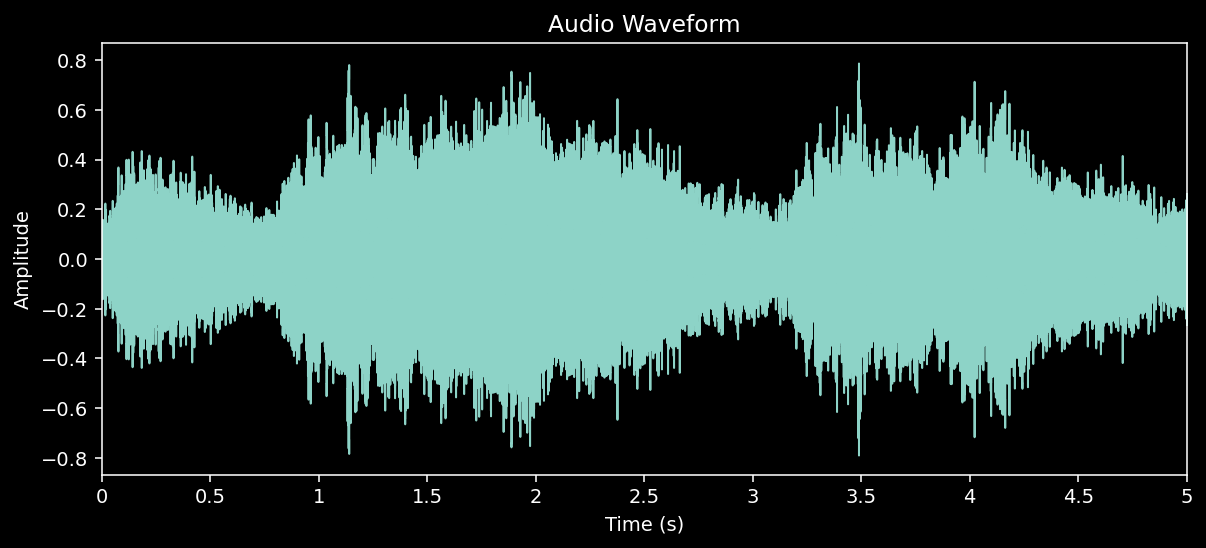

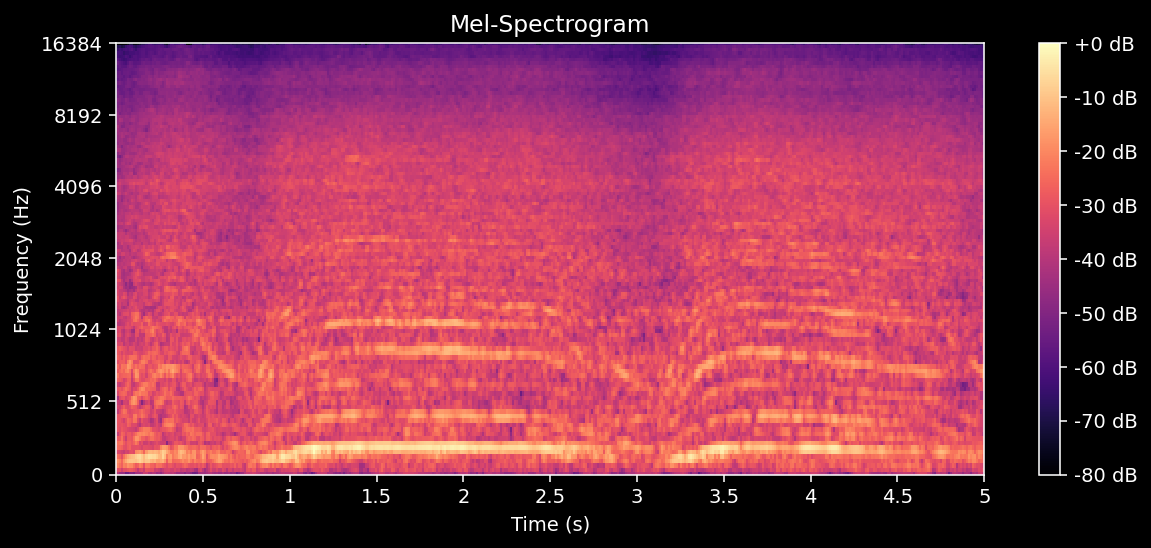

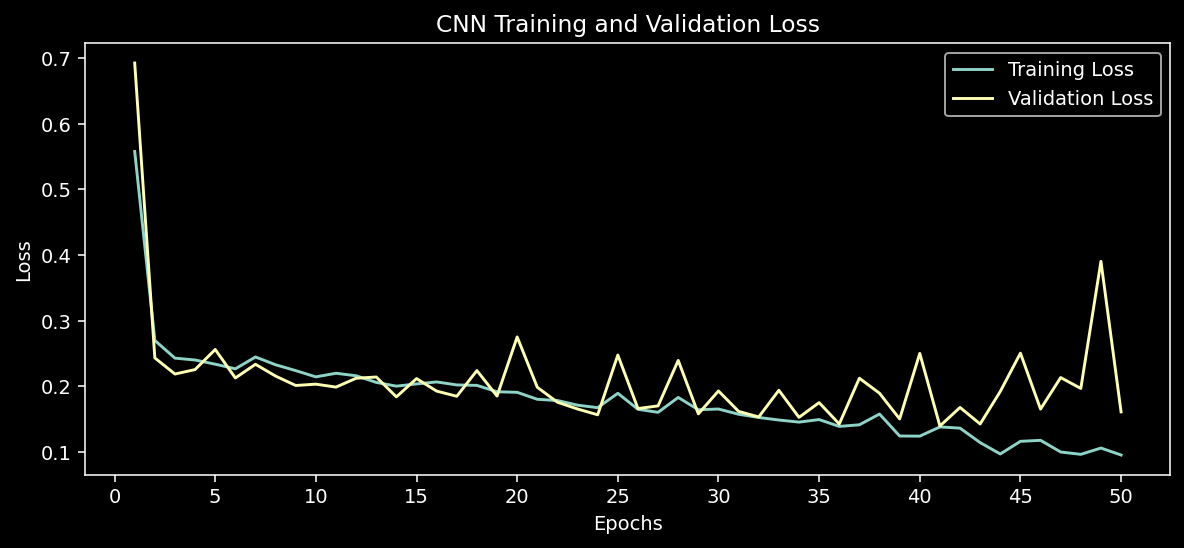

In [ ]:
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 140
import librosa
import librosa.display

plt.style.use('dark_background')

# Load a sample audio file
audio_path = '/content/drive/MyDrive/PROJECTS/Flatiron/Phase_4_Project/data/engine/5-170338-B-41.wav'
audio, sr = librosa.load(audio_path, sr=None)

# Plot audio waveform
plt.figure(figsize=(10, 4))
librosa.display.waveshow(audio, sr=sr)
plt.title('Audio Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim([0,5])
plt.show()

# Compute and plot Mel-spectrogram
mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.ylim([0,16384])
plt.xlim([0,5])
plt.show()

# Visualize training and validation loss
epochs = range(1, len(history.history['loss']) + 1)
plt.figure(figsize=(10, 4))
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('CNN Training and Validation Loss')
plt.xlabel('Epochs')
plt.xticks(range(0,epochs[-1]+1,5))
plt.ylabel('Loss')
plt.legend()
plt.show()

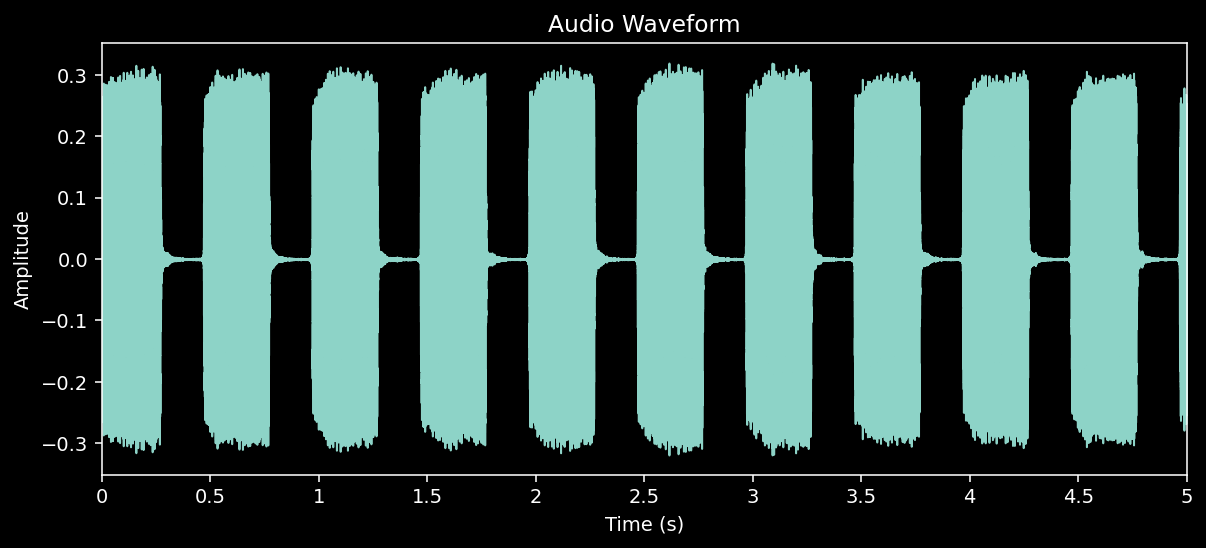

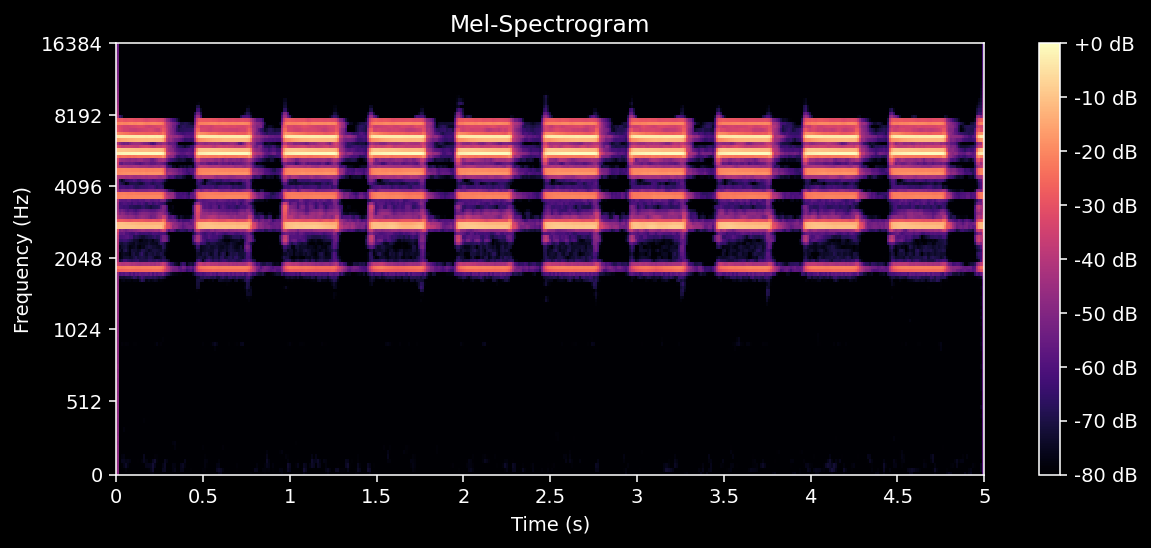

In [3]:
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 140
import librosa
import librosa.display

plt.style.use('dark_background')

# Load a sample audio file
audio_path = '/content/drive/MyDrive/PROJECTS/Flatiron/Phase_4_Project/data/non_engine/2-104476-A-37.wav'
audio, sr = librosa.load(audio_path, sr=None)

# Plot audio waveform
plt.figure(figsize=(10, 4))
librosa.display.waveshow(audio, sr=sr)
plt.title('Audio Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim([0,5])
plt.show()

# Compute and plot Mel-spectrogram
mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.ylim([0,16384])
plt.xlim([0,5])
plt.show()